<a href="https://colab.research.google.com/github/pratham023/ser_cnn/blob/main/colab_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
!unzip -o Audio_Speech_Actors_01-24.zip

--2026-02-07 14:23:31--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.184.103.118, 188.184.98.114, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2026-02-07 14:23:32--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip.1’

Audio_Speech_Actors 100%[===================>] 198.81M  17.9MB/s    in 12s     

2026-02-07 14:23:44 (16.9 MB/s) - ‘Audio_Speech_Actors_01-24.zip.1’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  

In [8]:
#List of training examples

import os
data_dir = "."
samples = []


#Hard coded emotion map
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

for actor in os.listdir(data_dir):
    if not actor.startswith("Actor_"):
        continue

    actor_path = os.path.join(data_dir, actor)
    if not os.path.isdir(actor_path):
        continue

    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = emotion_map[emotion_code]

            samples.append({
                "path": os.path.join(actor_path, file),
                "emotion": emotion
            })

print(len(samples))

1440


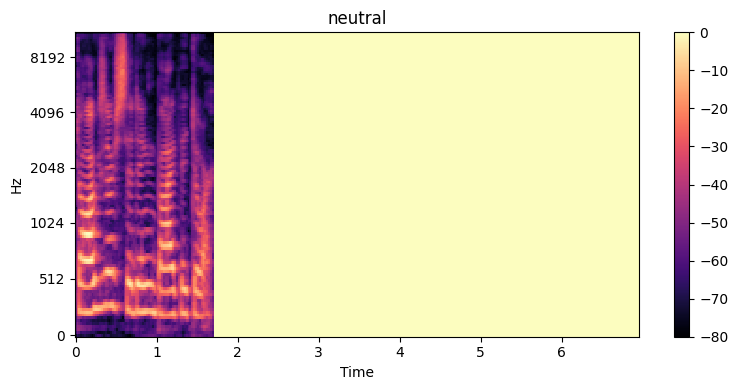

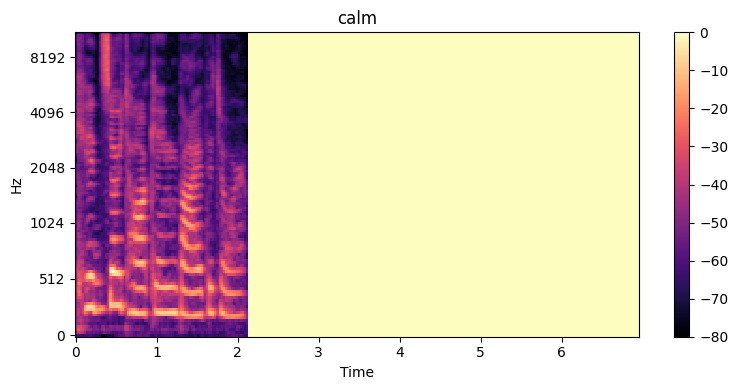

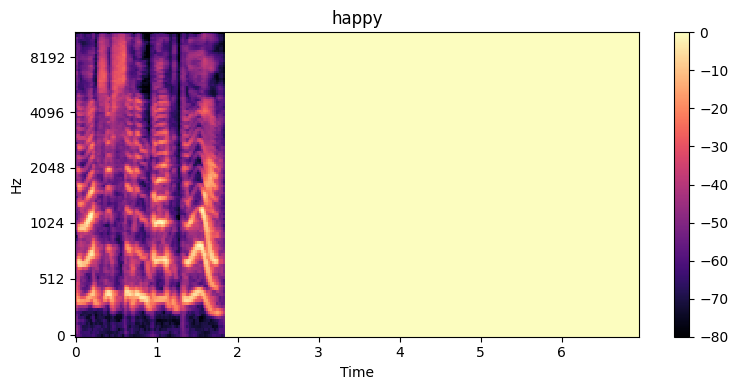

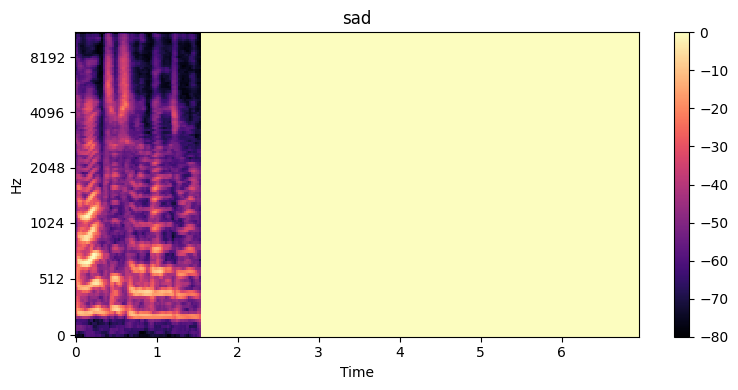

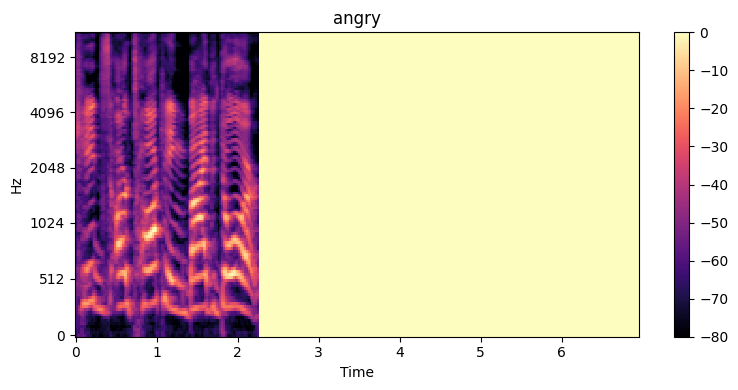

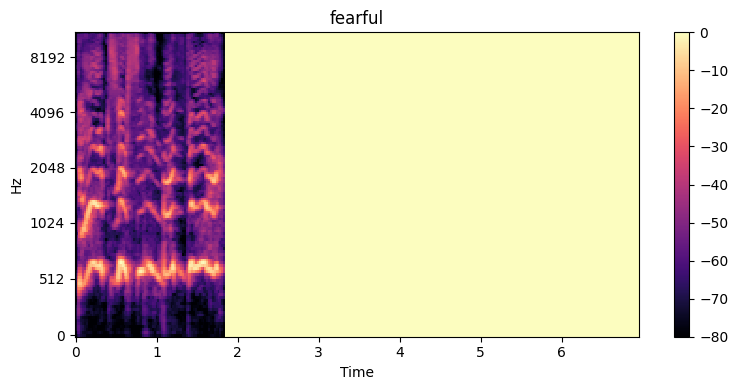

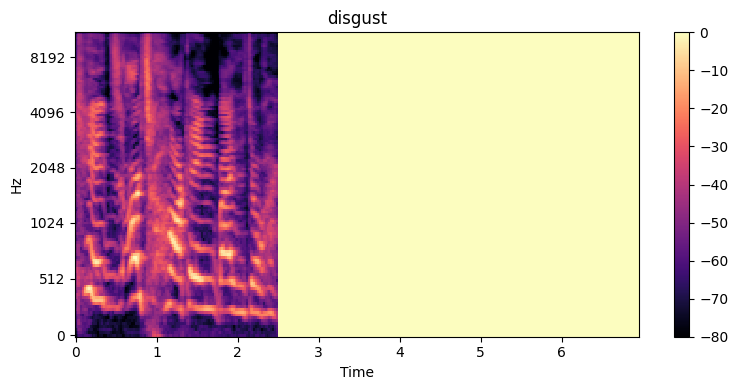

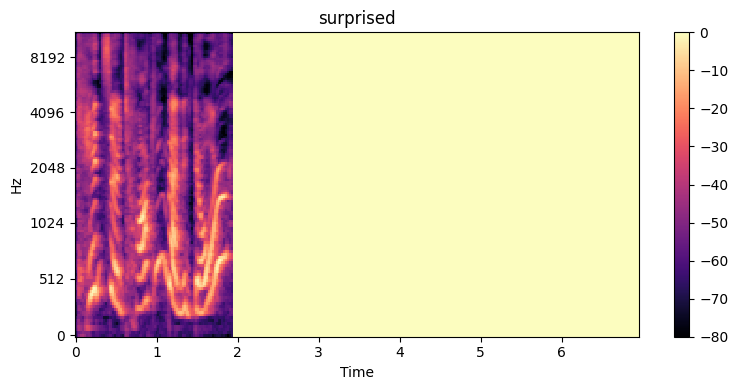

In [9]:
#Pre-processing
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random

def load_and_trim(path, sr=22050):
    y, sr = librosa.load(path, sr=sr) #Normalizes the samples to [-1, 1]
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)
    return y_trimmed, sr

MAX_FRAMES = 300

def wav_to_logmel(y, sr):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )
    logmel = librosa.power_to_db(mel, ref=np.max)

    if logmel.shape[1] < MAX_FRAMES:
        pad_width = MAX_FRAMES - logmel.shape[1]
        logmel = np.pad(logmel, ((0, 0), (0, pad_width)), mode="constant")
    else:
        logmel = logmel[:, :MAX_FRAMES]

    return logmel

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def pitch_shift(y, sr, steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate=rate)

def process_sample(path, augment=False):
    y, sr = load_and_trim(path)

    if augment:
        choice = random.choice(["noise", "pitch", "stretch", "none"])

        if choice == "noise":
            y = add_noise(y)
        elif choice == "pitch":
            y = pitch_shift(y, sr, steps=random.choice([-2, -1, 1, 2]))
        elif choice == "stretch":
            y = time_stretch(y, rate=random.uniform(0.9, 1.1))

    return wav_to_logmel(y, sr)

X = []
Y = []

for s in samples:
    mel = process_sample(s["path"], augment=True)
    X.append(mel)
    Y.append(s["emotion"])

X = np.array(X)

def show_mel(path, title):
    y, sr = load_and_trim(path)
    mel = wav_to_logmel(y, sr)

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mel, sr=sr, hop_length=512,
                             x_axis="time", y_axis="mel")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

emotions=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

for emotion in emotions:
  sample=next(s for s in samples if s["emotion"] == emotion)
  show_mel(sample["path"], emotion)

In [10]:
#Train-test split
import random
random.seed(10)
samples_shuffled = samples.copy()
random.shuffle(samples_shuffled)

# Calculate split indices
train_idx = int(len(samples_shuffled) * 0.8)
val_idx = int(len(samples_shuffled) * 0.9)

train_data = samples_shuffled[:train_idx]
val_data = samples_shuffled[train_idx:val_idx]
test_data = samples_shuffled[val_idx:]

In [15]:
#Converting to torch tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

emotion_to_idx = {
    "neutral": 0,
    "calm": 1,
    "happy": 2,
    "sad": 3,
    "angry": 4,
    "fearful": 5,
    "disgust": 6,
    "surprised": 7
}

class RAVDESSDataset(Dataset):
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        mel = process_sample(
            sample["path"],
            augment=self.augment
        )

        mel = torch.tensor(mel, dtype=torch.float32)
        mel = mel.unsqueeze(0)  # (1, 128, 300)

        label = emotion_to_idx[sample["emotion"]]
        label = torch.tensor(label, dtype=torch.long)

        return mel, label

from torch.utils.data import DataLoader

train_dataset = RAVDESSDataset(train_data, augment=True)
val_dataset = RAVDESSDataset(val_data, augment=False)
test_dataset = RAVDESSDataset(test_data, augment=False)

use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=use_cuda
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=use_cuda
)

In [16]:
#Training
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses, val_losses = [], []
train_f1, val_f1 = [], []

best_val_f1 = 0.0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0
    y_true_train, y_pred_train = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(outputs.argmax(dim=1).cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(y_true_train, y_pred_train, average="macro")
    train_losses.append(epoch_loss)
    train_f1.append(epoch_f1)

    # Validation phase
    model.eval()
    val_running_loss = 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * X_batch.size(0)
            y_true_val.extend(y_batch.cpu().numpy())
            y_pred_val.extend(outputs.argmax(dim=1).cpu().numpy())

    val_loss_epoch = val_running_loss / len(val_loader.dataset)
    val_f1_score_epoch = f1_score(y_true_val, y_pred_val, average="macro")
    val_losses.append(val_loss_epoch)
    val_f1.append(val_f1_score_epoch)

    # Save best model
    if val_f1_score_epoch > best_val_f1:
        best_val_f1 = val_f1_score_epoch
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train F1: {epoch_f1:.4f}, Val Loss: {val_loss_epoch:.4f}, Val F1: {val_f1_score_epoch:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/20 - Train Loss: 2.0327, Train F1: 0.1283, Val Loss: 2.0119, Val F1: 0.1360


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/20 - Train Loss: 1.9725, Train F1: 0.2192, Val Loss: 1.9651, Val F1: 0.1539


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/20 - Train Loss: 1.9392, Train F1: 0.2281, Val Loss: 1.9502, Val F1: 0.1992


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/20 - Train Loss: 1.9077, Train F1: 0.2662, Val Loss: 1.9099, Val F1: 0.1573


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/20 - Train Loss: 1.8632, Train F1: 0.2309, Val Loss: 1.8439, Val F1: 0.2495


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/20 - Train Loss: 1.8273, Train F1: 0.2699, Val Loss: 1.8266, Val F1: 0.2116


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/20 - Train Loss: 1.8042, Train F1: 0.2657, Val Loss: 1.8199, Val F1: 0.2282


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/20 - Train Loss: 1.7670, Train F1: 0.2941, Val Loss: 1.7535, Val F1: 0.2967


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/20 - Train Loss: 1.7600, Train F1: 0.3046, Val Loss: 1.7472, Val F1: 0.2584


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/20 - Train Loss: 1.7250, Train F1: 0.3115, Val Loss: 1.7475, Val F1: 0.2873


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/20 - Train Loss: 1.7066, Train F1: 0.3208, Val Loss: 1.9701, Val F1: 0.1233


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/20 - Train Loss: 1.6916, Train F1: 0.3029, Val Loss: 1.7402, Val F1: 0.2605


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/20 - Train Loss: 1.6644, Train F1: 0.3255, Val Loss: 1.8160, Val F1: 0.2594


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/20 - Train Loss: 1.6546, Train F1: 0.3244, Val Loss: 1.8383, Val F1: 0.1668


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/20 - Train Loss: 1.6375, Train F1: 0.3499, Val Loss: 1.6756, Val F1: 0.3222


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/20 - Train Loss: 1.6487, Train F1: 0.3295, Val Loss: 1.6516, Val F1: 0.2665


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/20 - Train Loss: 1.6285, Train F1: 0.3443, Val Loss: 1.5897, Val F1: 0.3636


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/20 - Train Loss: 1.6038, Train F1: 0.3505, Val Loss: 1.7228, Val F1: 0.2868


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/20 - Train Loss: 1.5884, Train F1: 0.3584, Val Loss: 1.8375, Val F1: 0.2022


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/20 - Train Loss: 1.5800, Train F1: 0.3334, Val Loss: 1.6369, Val F1: 0.3547


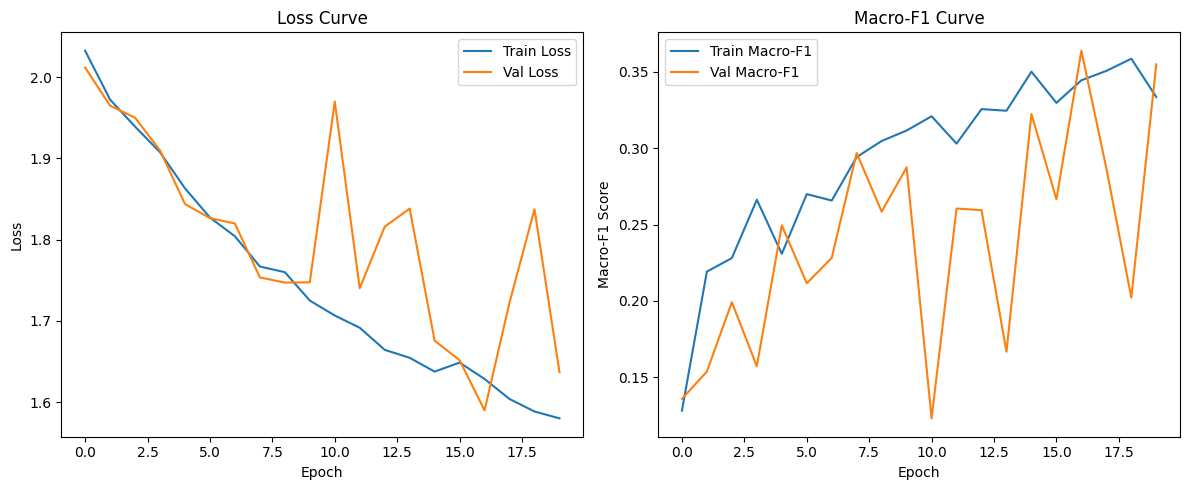

In [17]:
#Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_f1, label="Train Macro-F1")
plt.plot(val_f1, label="Val Macro-F1")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()
plt.title("Macro-F1 Curve")

plt.tight_layout()
plt.show()

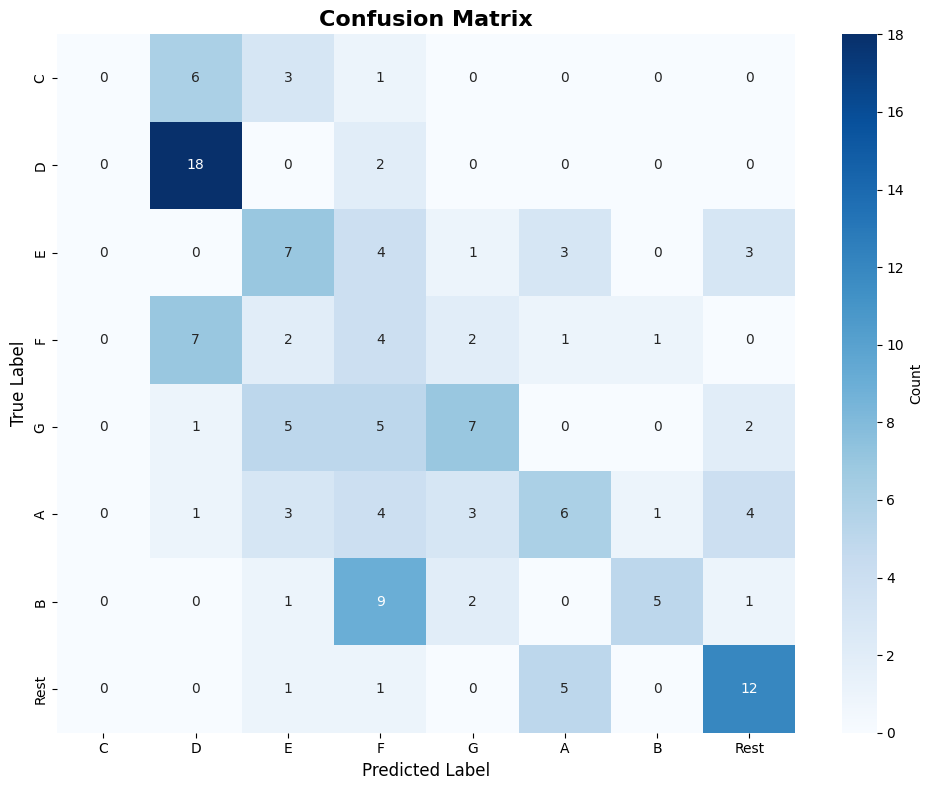


Classification Report:
              precision    recall  f1-score   support

           C       0.00      0.00      0.00        10
           D       0.55      0.90      0.68        20
           E       0.32      0.39      0.35        18
           F       0.13      0.24      0.17        17
           G       0.47      0.35      0.40        20
           A       0.40      0.27      0.32        22
           B       0.71      0.28      0.40        18
        Rest       0.55      0.63      0.59        19

    accuracy                           0.41       144
   macro avg       0.39      0.38      0.36       144
weighted avg       0.42      0.41      0.39       144


PITCH BIAS ANALYSIS

C:
  Support: 10
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  LOW RECALL - Model struggles to detect 'C'
  LOW PRECISION - Model over-predicts 'C'

D:
  Support: 20
  Precision: 0.5455
  Recall: 0.9000
  F1-Score: 0.6792

E:
  Support: 18
  Precision: 0.3182
  Recall: 0.3889
  F1-Score: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


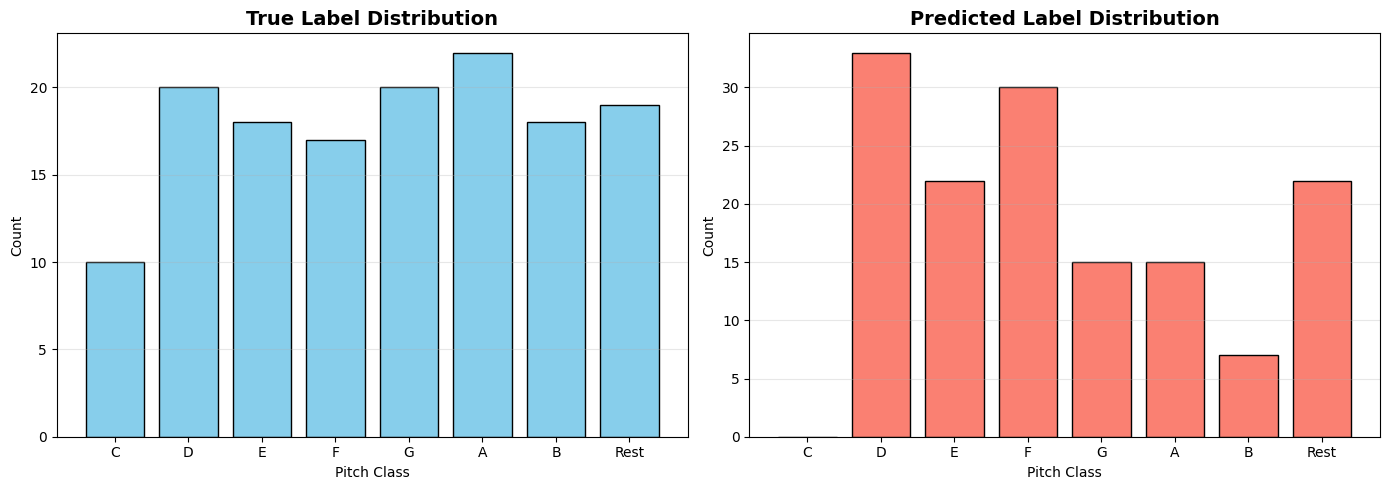

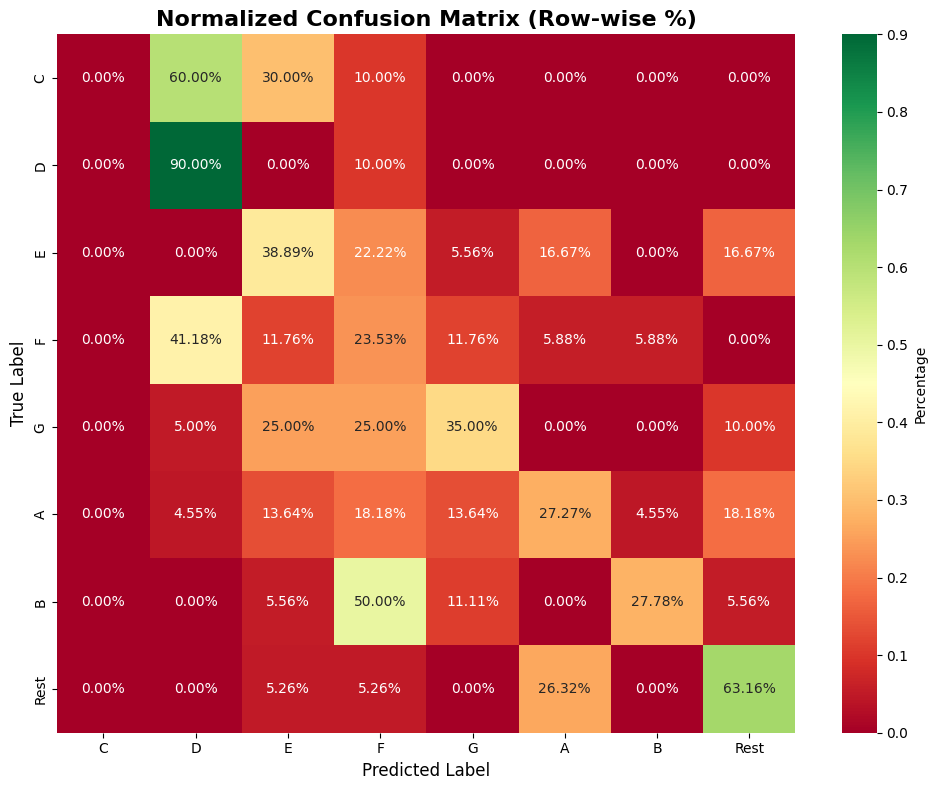

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        y_true_all.extend(y_batch.numpy())
        y_pred_all.extend(predictions)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

cm = confusion_matrix(y_true_all, y_pred_all)

pitch_classes = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'Rest']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pitch_classes,
            yticklabels=pitch_classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=pitch_classes))

print("\n" + "="*60)
print("PITCH BIAS ANALYSIS")
print("="*60)

for i, pitch in enumerate(pitch_classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    support = cm[i, :].sum()

    print(f"\n{pitch}:")
    print(f"  Support: {support}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    if recall < 0.5:
        print(f"  LOW RECALL - Model struggles to detect '{pitch}'")
    if precision < 0.5:
        print(f"  LOW PRECISION - Model over-predicts '{pitch}'")

print("\n" + "="*60)
print("OVERALL BIAS METRICS")
print("="*60)

true_distribution = np.bincount(y_true_all, minlength=len(pitch_classes))
pred_distribution = np.bincount(y_pred_all, minlength=len(pitch_classes))

print("\nClass Distribution:")
print(f"{'Pitch':<10} {'True Count':<15} {'Pred Count':<15} {'Difference':<15}")
print("-" * 60)
for i, pitch in enumerate(pitch_classes):
    diff = pred_distribution[i] - true_distribution[i]
    bias_indicator = "📈 Over-predicted" if diff > 0 else "📉 Under-predicted" if diff < 0 else "✓ Balanced"
    print(f"{pitch:<10} {true_distribution[i]:<15} {pred_distribution[i]:<15} {diff:<15} {bias_indicator}")

bias_scores = (pred_distribution - true_distribution) / (true_distribution + 1e-8)
print("\nBias Scores (positive = over-prediction, negative = under-prediction):")
for i, pitch in enumerate(pitch_classes):
    print(f"  {pitch}: {bias_scores[i]:+.4f}")

most_biased_idx = np.argmax(np.abs(bias_scores))
print(f"\n🎯 Most biased pitch: {pitch_classes[most_biased_idx]} (bias score: {bias_scores[most_biased_idx]:+.4f})")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(pitch_classes, true_distribution, color='skyblue', edgecolor='black')
axes[0].set_title('True Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pitch Class')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(pitch_classes, pred_distribution, color='salmon', edgecolor='black')
axes[1].set_title('Predicted Label Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pitch Class')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=pitch_classes,
            yticklabels=pitch_classes,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Row-wise %)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
'''#predict.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
import sys

MAX_FRAMES = 300

class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def load_and_trim(path, sr=22050):
    y, sr = librosa.load(path, sr=sr)
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)
    return y_trimmed, sr

def wav_to_logmel(y, sr):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    if logmel.shape[1] < MAX_FRAMES:
        pad_width = MAX_FRAMES - logmel.shape[1]
        logmel = np.pad(logmel, ((0, 0), (0, pad_width)), mode="constant")
    else:
        logmel = logmel[:, :MAX_FRAMES]
    return logmel

def process_sample(path):
    y, sr = load_and_trim(path)
    return wav_to_logmel(y, sr)

def predict_emotion(wav_path, model_path='best_model.pth'):
    idx_to_emotion = {
        0: "neutral",
        1: "calm",
        2: "happy",
        3: "sad",
        4: "angry",
        5: "fearful",
        6: "disgust",
        7: "surprised"
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CNN()
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    model.to(device)
    model.eval()

    mel = process_sample(wav_path)
    mel_tensor = torch.tensor(mel, dtype=torch.float32)
    mel_tensor = mel_tensor.unsqueeze(0).unsqueeze(0)
    mel_tensor = mel_tensor.to(device)

    with torch.no_grad():
        output = model(mel_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        predicted_emotion = idx_to_emotion[predicted.item()]
        confidence_percentage = confidence.item() * 100

    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence: {confidence_percentage:.2f}%")

    return predicted_emotion, confidence_percentage

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python predict.py <path_to_wav_file> [model_path]")
        print("Example: python predict.py audio.wav")
        print("Example: python predict.py audio.wav best_model.pth")
        sys.exit(1)

    wav_file = sys.argv[1]
    model_file = sys.argv[2] if len(sys.argv) > 2 else 'best_model.pth'

    emotion, confidence = predict_emotion(wav_file, model_file)'''